# 本节需要的函数


In [ ]:
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

# 神经网络的学习

上一节也看到了，随机生成的参数要是能有高准确率那就有鬼了。当然，几千个参数靠人来设置也不现实。所以需要靠计算机来自动调整：

* 对于一般的机器学习，机器会根据样本的“特征”来调整参数，而特征是由人来设置的。
* 对于神经网络，我们直接将整个样本输入到网络，无需设置任何特征。

因此神经网络的应用范围更广。

## 训练数据与测试数据

训练数据用于训练神经网络，寻找最优参数。

测试数据用来测试神经网络。

为什么要这样划分？因为如果只用训练数据来测试，那么很有可能神经网络只能识别训练数据，而无法识别其他数据。就好像做题，如果只做一类题，那就有可能在考试时做不出新的类型的题目了。这种做考试题的能力，在深度学习中叫 **泛化**；而只会做一类题叫 **过拟合**。

## 损失函数

我们用 **损失函数 loss function** 来衡量神经网络的误差。

### 均方误差

最简单的损失函数就是均方误差：

$$
E = \frac{1}{2} \sum_k (y_k - t_k)^2
$$



In [ ]:
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

y1 = np.array([0.1,0.7,0.2])
y2 = np.array([0.1,0.5,0.4])
t = np.array([0,1,0])

[mean_squared_error(t,t),
 mean_squared_error(y1,t),
 mean_squared_error(y2,t)]

[0.0, 0.07000000000000002, 0.21000000000000002]

### 交叉熵误差

$$
E=-\sum_k t_k \log y_k
$$

输出的值只取决于正确标签对应的输出。如果输出是 $y=1$，则 $E=0$；如果输出 $y<1$，则 $E>0$。

batch 学习的交叉熵误差：

$$
E=-\frac{1}{N} \sum_n \sum_k t_{n,k} \log y_{n,k}
$$

相当是所有训练数据的误差平均值。

In [ ]:
import numpy as np

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    
    #加上微小值防止出现负无穷
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size 

y1 = np.array([0.1,0.7,0.2])
y2 = np.array([0.1,0.5,0.4])
t = np.array([0,1,0])

[cross_entropy_error(t,t),
 cross_entropy_error(y1,t),
 cross_entropy_error(y2,t)]

[-9.999999505838704e-08, 0.3566748010815999, 0.6931469805599654]

## 能不能用准确率来作为损失函数

显然是不能的。准确率指的是有多少个是正确的，比如100个数据中有32个正确，那精度就是32%。显然，准确率是不连续的，或者说是突变的，这样我们如果微调参数，那么准确率是不会变化的，这样就无法确定应该向哪个方向调整参数。这和阶跃函数无法作为激活函数的理由是一样的。

## 梯度

假如神经网络可以写成一个函数 $y=f(w, x)$ ，误差函数为 $L(f(w, x))$ ，为了使函数更准确，也就是误差函数最小。那么根据梯度的定义，我们可以向梯度方向减小参数：

$$
w_0' = w_0 - \eta\frac{\partial L(f(x,w))}{\partial w_0}
$$

$\eta$ 称为**学习率**

下面我们来看看如何求网络的梯度：


In [ ]:
def numerical_gradient(f, x): #笨方法求梯度
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h) #取相近两点求斜率
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

In [ ]:
import numpy as np



class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) #随机生成参数

    def predict(self, x): #预测
        return np.dot(x, self.W)

    def loss(self, x, t): #计算误差
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(net.loss(x,t))
print(dW)

0.2698596081175344
[[ 0.11629091  0.02561713 -0.14190804]
 [ 0.17443636  0.03842569 -0.21286206]]


求完梯度后更新梯度：

In [ ]:
eta = 1

print(net.W)
print(net.loss(x,t))

for i in range(10): #利用梯度下降法更新十次参数
    net.W = net.W - eta*numerical_gradient(f, net.W)

print(net.W)
print(net.loss(x,t))

[[-0.52760346 -0.60826468  0.14784348]
 [-0.53011149 -2.15726367  0.54289599]]
0.2698596081175344
[[-0.98917483 -0.74641069  0.74756086]
 [-1.22246854 -2.36448269  1.44247207]]
0.044317052837686284


可以看出，训练 10 次后，误差已经减小了 2 个数量级。这就是我们希望达到的目标

# 回到MNIST数据集

我们尝试用一个两层的网络来识别 MNIST 数据集，我们将定义一个 TwoLayerNet，并实现相关的函数（预测、损失函数、精度、梯度……）

In [ ]:
class TwoLayerNet: #一个简单的两层网路

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) #权重
        self.params['b1'] = np.zeros(hidden_size) #偏置
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])  
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [ ]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
from IPython.terminal.embed import InteractiveShellEmbed
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

## if you run in terminal, run this
# dataset_dir = os.path.dirname(os.path.abspath(__file__))
## if you run in IPython, run this
ip_shell = InteractiveShellEmbed()
dataset_dir = ip_shell.magic("%pwd")

save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """读入MNIST数据集
    
    Parameters
    ----------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label : 
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组
    
    Returns
    -------
    (训练图像, 训练标签), (测试图像, 测试标签)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


train acc, test acc | 0.09863333333333334, 0.0958
train acc, test acc | 0.7995166666666667, 0.8065
train acc, test acc | 0.8767, 0.8792
train acc, test acc | 0.898, 0.9016
train acc, test acc | 0.9086333333333333, 0.9114
train acc, test acc | 0.9147666666666666, 0.9157
train acc, test acc | 0.91985, 0.9204
train acc, test acc | 0.9245, 0.9257
train acc, test acc | 0.9285666666666667, 0.93
train acc, test acc | 0.9315, 0.9325
train acc, test acc | 0.93455, 0.9357
train acc, test acc | 0.9379166666666666, 0.9383
train acc, test acc | 0.94035, 0.9403
train acc, test acc | 0.9420166666666666, 0.9408
train acc, test acc | 0.9448666666666666, 0.9442
train acc, test acc | 0.9472833333333334, 0.9468
train acc, test acc | 0.9488166666666666, 0.947


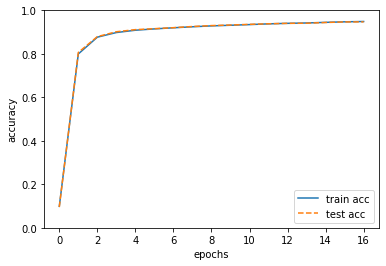

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()